In [123]:
import os
import pandas as pd
import numpy as np
from IPython.display import display
from matplotlib import pyplot as plt

In [124]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Doing FSS analysis via the method nonlinear least squares

If we use new rescaled variables
\begin{align*}
X &= (x-x)L^{c_1},\\
Y &= A/L^{-c_2} = A L^{c_2},
\end{align*}
then the FSS law writes
$$
Y = \mathscr{F}[X],
$$
such that rescaled data points $(X_\theta, Y_\theta)_i = (X_i, Y_i)$, fall onto a single scaling function $\mathscr{F}$ (i.e., the master curve).

we are particularly interested in scaling laws that govern the shape of master curves for conditional aggregate impact $R(\Delta V^\prime, T)$.

where we have an explicit generating functional  $\mathscr{F}(x)$  to compute.

### Preparation
The following modules are required

In [125]:
from liquidity.features import compute_aggregate_features

from market_impact.util.utils import bin_data_into_quantiles, smooth_outliers
from market_impact.response_functions.price_response_functions import compute_conditional_impact

In [126]:
# BIN_SIZE = list(range(1, 150))
# BIN_SIZE = [50, 100, 150, 200, 250]
BIN_SIZE = list(range(10, 250, 10))
OBSERVATION_WINDOWS = [5, 10, 20, 50, 100]

The following are special modules for conducting the FSS by method of LS.

In [127]:
from market_impact.response_functions.fss import find_shape_parameters, find_scale_factors, transform

### Dataset

We first prepare the data. Each entry of the orderbook data correpsonds to a single event of type $\pi$ (trade execution, limit order deposit or cancellation) in the orderbook for a given asset (say a stock, APPL or TSLA).

In [128]:
current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..')
data_dir = os.path.join(root_dir, 'dataset', 'LO_sample')
filename = "AMZN-2017-NEW.csv" # APPLE Example
stock_file_path = os.path.join(data_dir, filename)
aapl_orderbook_states = pd.read_csv(stock_file_path)
display(aapl_orderbook_states)

,Unnamed: 0,event_timestamp,side,lob_action,order_executed,execution_price,execution_size,ask,ask_volume,bid,...,sign,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,390273,2017-01-03 10:30:01.413328333,ASK,INSERT,False,NaN,0,0.00,0.0,0.00,...,1,755.925,755.925,0.00,2017-01-03,0.035696,1166443,16117,0.876150,100
1,390303,2017-01-03 10:30:04.434831516,BID,INSERT,False,NaN,0,756.14,2.0,755.71,...,-1,0.000,-0.000,0.43,2017-01-03,0.035696,1166443,16117,0.634288,-100
2,390308,2017-01-03 10:30:04.897653064,BID,INSERT,False,NaN,0,756.14,2.0,755.71,...,-1,0.010,-0.010,0.43,2017-01-03,0.035696,1166443,16117,0.634288,-100
3,390315,2017-01-03 10:30:05.455967414,BID,INSERT,False,NaN,0,756.14,2.0,755.73,...,-1,0.000,-0.000,0.41,2017-01-03,0.035696,1166443,16117,0.038057,-6
4,390329,2017-01-03 10:30:06.670219376,ASK,INSERT,False,NaN,0,756.14,2.0,755.73,...,1,-0.020,-0.020,0.41,2017-01-03,0.035696,1166443,16117,0.569497,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937175,146414,2017-12-29 14:59:54.499379166,ASK,INSERT,False,NaN,0,1170.89,60.0,1170.76,...,1,-0.065,-0.065,0.13,2017-12-29,-0.014813,564276,15104,0.140454,15
3937176,146421,2017-12-29 14:59:54.531701098,BID,INSERT,False,NaN,0,1170.92,1651.0,1170.60,...,-1,0.050,-0.050,0.32,2017-12-29,-0.014813,564276,15104,0.821716,-100
3937177,146425,2017-12-29 14:59:54.794697347,BID,INSERT,False,NaN,0,1170.92,1651.0,1170.70,...,-1,0.000,-0.000,0.22,2017-12-29,-0.014813,564276,15104,0.821716,-100
3937178,146429,2017-12-29 14:59:57.939337264,ASK,INSERT,False,NaN,0,1170.92,1651.0,1170.70,...,1,-0.005,-0.005,0.22,2017-12-29,-0.014813,564276,15104,10.299989,1100


 We first coarse-grain this data into different bin sizes, we marginalize over microscopic degrees of freedom in the system to yield an effective coarse-grained description at long distances.

In [129]:
aggregate_features = compute_aggregate_features(aapl_orderbook_states, BIN_SIZE)
display(aggregate_features)

,event_timestamp,midprice,sign,signed_volume,daily_R1,daily_vol,daily_num,volume_imbalance,sign_imbalance,T
0,2017-01-03 10:30:01.413328333,0.000,1,100,0.035696,1166443,16117,-0.000087,0.000000,10
1,2017-01-03 10:30:10.132729215,755.935,-1,-31,0.035696,1166443,16117,-0.000492,-0.000496,10
2,2017-01-03 10:30:12.175154801,756.150,-1,-100,0.035696,1166443,16117,-0.000187,-0.000620,10
3,2017-01-03 10:30:12.339765159,756.155,-1,-100,0.035696,1166443,16117,-0.000505,-0.000620,10
4,2017-01-03 10:30:13.431796025,756.165,-1,-100,0.035696,1166443,16117,-0.000385,-0.000620,10
...,...,...,...,...,...,...,...,...,...,...
16400,2017-12-29 14:33:01.629432288,1172.820,-1,-4,-0.014813,564276,15104,0.012545,0.003178,240
16401,2017-12-29 14:38:41.326765524,1171.630,-1,-10,-0.014813,564276,15104,0.015009,0.006621,240
16402,2017-12-29 14:43:41.526037612,1170.715,1,100,-0.014813,564276,15104,0.001965,0.002251,240
16403,2017-12-29 14:49:18.138741331,1170.220,-1,-99,-0.014813,564276,15104,-0.003009,0.001192,240


### Data normalization

From aggregate features, we can then compute conditional aggregate impact. Each line of our aggregate feature data will be converted into an aggregate impact dataframe consisting of three values {system size $T$, temperature $x$, observable $A$}. In our case these correspond to the contemporaneous bin size $T$, orderflow imbalance $\Delta V$ and aggregate returns $R$ respectively.

All data are automatically rescaled in preparation for a finite-size scaling. In particular, the temperature $\Delta V$ and observable $R$ are rescaled each day by their corresponding values of $\mathcal{R}(1)$ and either the average queue volume $\overline{V}_{\mathrm{best}}$ or  daily volume  $V_D$  that represent constants of unit dimension that define a characteristic length scale. A similar rescaling works well for different asset classes.

In [130]:
# Compute data for susceptibility – conditional aggregate impact
normalized_data = compute_conditional_impact(aggregate_features)
display(normalized_data)

,event_timestamp,midprice,sign,signed_volume,daily_R1,daily_vol,daily_num,volume_imbalance,sign_imbalance,T,R
0,2017-01-03 10:30:01.413328333,0.000,1,100,0.035696,1166443,16117,-0.000087,0.000000,10,21176.744064
1,2017-01-03 10:30:10.132729215,755.935,-1,-31,0.035696,1166443,16117,-0.000492,-0.000496,10,6.023005
2,2017-01-03 10:30:12.175154801,756.150,-1,-100,0.035696,1166443,16117,-0.000187,-0.000620,10,0.140070
3,2017-01-03 10:30:12.339765159,756.155,-1,-100,0.035696,1166443,16117,-0.000505,-0.000620,10,0.280140
4,2017-01-03 10:30:13.431796025,756.165,-1,-100,0.035696,1166443,16117,-0.000385,-0.000620,10,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
16400,2017-12-29 14:33:01.629432288,1172.820,-1,-4,-0.014813,564276,15104,0.012545,0.003178,240,-80.335039
16401,2017-12-29 14:38:41.326765524,1171.630,-1,-10,-0.014813,564276,15104,0.015009,0.006621,240,-61.770219
16402,2017-12-29 14:43:41.526037612,1170.715,1,100,-0.014813,564276,15104,0.001965,0.002251,240,-33.416676
16403,2017-12-29 14:49:18.138741331,1170.220,-1,-99,-0.014813,564276,15104,-0.003009,0.001192,240,-34.429303


### $1.$ Determine shape parameters $\alpha$ and $\beta$
In order to determine the shape paremeters, the shape, the scaling form $R(\Delta V^\prime, T)$ is fitted for $\textit{all}$ $T$s using the scaling form Eq. X.

In [131]:
from market_impact import fit_scaling_form


def find_shape_parameters_inverse(normalized_data: pd.DataFrame):
    """
    :param normalized_data: normalized dataframe consisting {system_size_T, temperature_x, observable_A}
    which map over to observationw windows, orderflowimbalance and aggregate impact {T, imbalance, R} respective.
    :return: shape_parameters: a list consisting of scaling form shape parameters alpha and beta.
    """
    data = normalized_data.copy()

    # Extract variables describing the system
    T_values = data['T'].values
    volume_imbalance_values = -data['volume_imbalance'].values
    R_values = data['R'].values

    # Find scaling form shape parameters
    RN, QN, alpha, beta, CONST = fit_scaling_form(T_values, volume_imbalance_values, R_values)
    shape_params = [alpha, beta]

    return shape_params

In [132]:
alpha, beta = find_shape_parameters_inverse(normalized_data)
print(f'alpha: {alpha}')
print(f'beta: {beta}')

alpha: 0.4070916698617473
beta: 3.7118851913541935


In [133]:
normalized_data

,event_timestamp,midprice,sign,signed_volume,daily_R1,daily_vol,daily_num,volume_imbalance,sign_imbalance,T,R
0,2017-01-03 10:30:01.413328333,0.000,1,100,0.035696,1166443,16117,-0.000087,0.000000,10,21176.744064
1,2017-01-03 10:30:10.132729215,755.935,-1,-31,0.035696,1166443,16117,-0.000492,-0.000496,10,6.023005
2,2017-01-03 10:30:12.175154801,756.150,-1,-100,0.035696,1166443,16117,-0.000187,-0.000620,10,0.140070
3,2017-01-03 10:30:12.339765159,756.155,-1,-100,0.035696,1166443,16117,-0.000505,-0.000620,10,0.280140
4,2017-01-03 10:30:13.431796025,756.165,-1,-100,0.035696,1166443,16117,-0.000385,-0.000620,10,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
16400,2017-12-29 14:33:01.629432288,1172.820,-1,-4,-0.014813,564276,15104,0.012545,0.003178,240,-80.335039
16401,2017-12-29 14:38:41.326765524,1171.630,-1,-10,-0.014813,564276,15104,0.015009,0.006621,240,-61.770219
16402,2017-12-29 14:43:41.526037612,1170.715,1,100,-0.014813,564276,15104,0.001965,0.002251,240,-33.416676
16403,2017-12-29 14:49:18.138741331,1170.220,-1,-99,-0.014813,564276,15104,-0.003009,0.001192,240,-34.429303


### $2.$ Map out scale factors $V_T$ and $R_T$ and determine thier behaviour.

In order to determine the scaling hehaviour and rescaling exponents $\chi$ and $\varkappa$ that follow, the shape of RN(\Delta V, T) is fitted for $\textit{each}$ T using the scaling form Eq. X with the scaling function $\mathscr{F}(x)$ given by Eq. X whilst keeping the preveously found values values of $\alpha$ nad $\beta$ constant. Note that the fitting of the aggregate impact curve that yield  $R_T, Q_T$ for each T did not impose any assumptions on their scaling.

In [134]:
RN_series, QN_series, RN_fit_object, QN_fit_object, fit_results_per_lag = find_scale_factors(normalized_data, alpha=alpha, beta=beta, inverse_x=True)

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")


[]

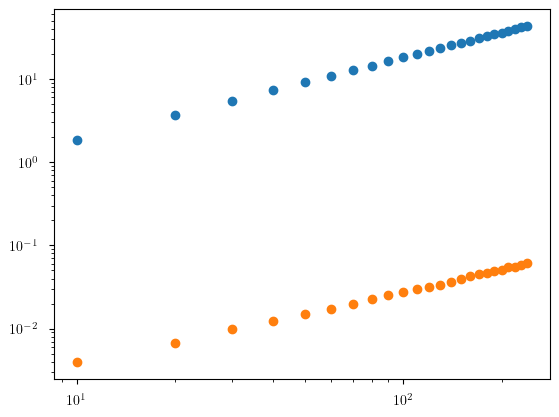

In [135]:
# Plot scale factors RN and QN
plt.scatter(RN_series['x_values'],RN_series['y_values'])
plt.scatter(QN_series['x_values'],QN_series['y_values'])
plt.loglog()

#### $2.2.$ From mapped out scale factors, determine scaling exponents $\chi$ and $\varkappa$

In [136]:
chi = RN_fit_object.powerlaw.params.alpha
kappa = QN_fit_object.powerlaw.params.alpha
print(chi)
print(kappa)

0.9972570396935709
0.9307408165856531



For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 110.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.18286461474501675
alpha = 0.9972570396935709

Goodness of fit to data;
D = 0.07142857142857142
bic = -78.95711253641451
mape = 0.08033906063026405
Adjusted R-squared = 0.9999500404329555



For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 110.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.00037151938960851825
alpha = 0.9307408165856531

Goodness of fit to data;
D = 0.07142857142857142
bic = -193.94129387136033
mape = 1.4051393008614723
Adjusted R-squared = 0.9925690775163872




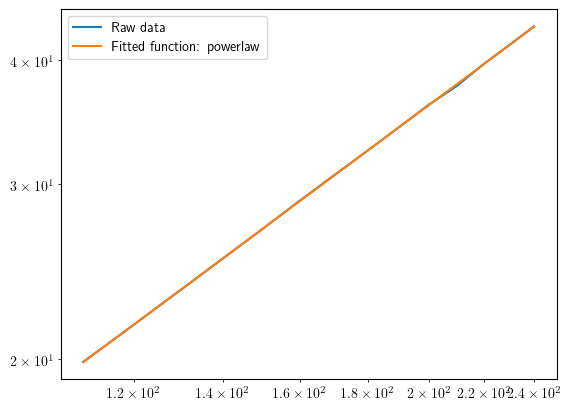

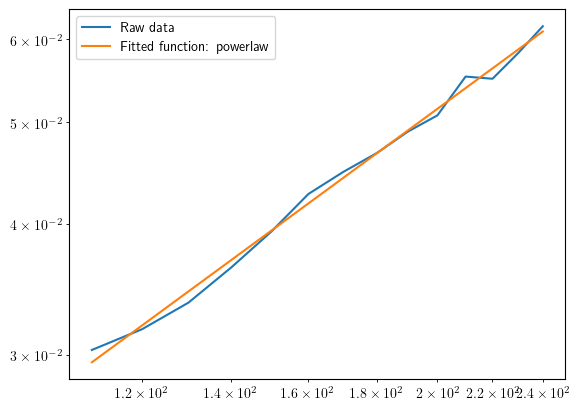

In [137]:
# Fit results
RN_fit_object.powerlaw.fit_results()
QN_fit_object.powerlaw.fit_results()
RN_fit_object.powerlaw.plot_fit()
QN_fit_object.powerlaw.plot_fit()

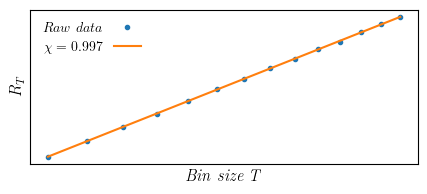

In [138]:
fig = plt.figure(figsize=(5, 2))
ax = fig.gca()

exponent = round(RN_fit_object.powerlaw.params.alpha, 3)
fit_label = f'$\chi = {exponent}$'
RN_fit_object.powerlaw.plot_fit(fit_kwargs={"ax": ax, "label": fit_label}, data_kwargs = {"label": "$Raw\ data$", "marker":".", "linestyle": "None"})
ax.tick_params(bottom=True, top=True, left=True, right=True, direction="in", width=0.5, size=3)
ax.minorticks_off()

legend = ax.legend(markerfirst=False)
legend.get_frame().set_edgecolor('w')
xlabel = r"$\it{Bin\ size\ T}$"
ylabel = r"$R_T$"
ax.set_xlabel(xlabel, fontsize=12)
ax.set_ylabel(ylabel, fontsize=12)
plt.savefig("lo-RN", dpi=150)
plt.show()

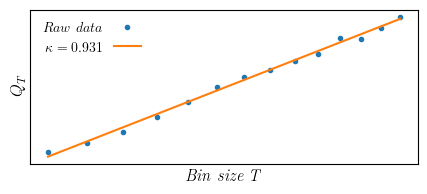

In [139]:
fig = plt.figure(figsize=(5, 2))
ax = fig.gca()

exponent = round(QN_fit_object.powerlaw.params.alpha, 3)
fit_label = f'$\kappa = {exponent}$'
QN_fit_object.powerlaw.plot_fit(fit_kwargs={"ax": ax, "label": fit_label}, data_kwargs = {"label": "$Raw\ data$", "marker":".", "linestyle": "None"})
ax.tick_params(bottom=True, top=True, left=True, right=True, direction="in", width=0.5, size=3)
ax.minorticks_off()

legend = ax.legend(markerfirst=False)
legend.get_frame().set_edgecolor('w')
xlabel = r"$\it{Bin\ size\ T}$"
ylabel = r"$Q_T$"
ax.set_xlabel(xlabel, fontsize=12)
ax.set_ylabel(ylabel, fontsize=12)
plt.savefig("lo-QN", dpi=150)
plt.show()

In [140]:
# Compare against alternative heavy-tailed hypothesis
print("Power law vs. powerlaw_with_exp_svf")
R, p = RN_fit_object.function_compare("powerlaw", "exponential_function")
R, p = RN_fit_object.function_compare("powerlaw", "lognormal_function")

RN_fit_object.return_all_fitting_results()

Power law vs. powerlaw_with_exp_svf


/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")


,name,xmin_index,xmin,fitting param,D,bic,mape,adjusted r-squared
0,powerlaw,10,110.0,"{'param_names': ['C', 'alpha'], 'C': 0.1828646...",0.0714,-78.9571,0.0803,1.0000
1,OLS,10,110.0,"{'param_names': ['C', 'alpha'], 'C': 0.1831922...",0.0714,-78.9185,0.0833,0.9999
2,GeneralisedRegression,10,110.0,"{'param_names': ['C', 'alpha'], 'C': 0.1831922...",0.0714,-78.9185,0.0833,0.9999
3,RobustRegression,10,110.0,"{'param_names': ['C', 'alpha'], 'C': 0.1824145...",0.0714,-78.1761,0.0737,0.9999
4,exponential_function,10,110.0,"{'param_names': ['beta', 'lambda_'], 'beta': 1...",0.0714,-1.0682,2.1456,0.9870
5,lognormal_function,10,110.0,"{'param_names': ['mu', 'sigma'], 'mu': 0.0, 's...",1.0000,105.2804,100.0000,-24.9332


In [141]:
# Compare against alternative heavy-tailed hypothesis
print("Power law vs. powerlaw_with_exp_svf")
R, p = QN_fit_object.function_compare("powerlaw", "exponential_function")
R, p = QN_fit_object.function_compare("powerlaw", "lognormal_function")

QN_fit_object.return_all_fitting_results()

Power law vs. powerlaw_with_exp_svf


/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")


,name,xmin_index,xmin,fitting param,D,bic,mape,adjusted r-squared
0,powerlaw,10,110.0,"{'param_names': ['C', 'alpha'], 'C': 0.0003715...",0.0714,-193.9413,1.4051,0.9926
1,OLS,10,110.0,"{'param_names': ['C', 'alpha'], 'C': 0.0003754...",0.0714,-193.9271,1.4077,0.9926
2,GeneralisedRegression,10,110.0,"{'param_names': ['C', 'alpha'], 'C': 0.0003754...",0.0714,-193.9271,1.4077,0.9926
3,RobustRegression,10,110.0,"{'param_names': ['C', 'alpha'], 'C': 0.0003754...",0.0714,-193.9271,1.4077,0.9926
4,exponential_function,10,110.0,"{'param_names': ['beta', 'lambda_'], 'beta': 0...",0.0714,-180.0762,2.5868,0.9800
5,lognormal_function,10,110.0,"{'param_names': ['mu', 'sigma'], 'mu': 0.0, 's...",1.0000,-78.0386,100.0000,-28.2728


### $3.1$ Plot the scaling law before and after the transforming

We can now substitute the found emeprical scaling laws for RN and QN and use this law fit the final shape parameters $\alpha$ and $\beta$, and rescaling exponents $\chi$ and $\varkappa$.

In [142]:
from market_impact.response_functions.fss import fit_scaling_law
from market_impact.response_functions.functional_form import scaling_function, scaling_law

# Plot final rescaled functions
OBSERVATION_WINDOWS = [x for x in OBSERVATION_WINDOWS if x in QN_series['x_values'].values]

# Smooth data for plotting purposes
smoothed_data = smooth_outliers(normalized_data.copy())

fit_param = {}
for T in OBSERVATION_WINDOWS:
    data = normalized_data[normalized_data['T']==T][["T", "volume_imbalance", "R"]]
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    binned_data = bin_data_into_quantiles(data, q=len(BIN_SIZE), duplicates="drop")

    T_values = binned_data['T'].values
    volume_imbalance = binned_data['volume_imbalance'].values
    R_values = binned_data['R'].values

    params = fit_scaling_law(T_values, -volume_imbalance, R_values)
    fit_param[T] = params

In [143]:
fit_param

{10: array([ 2.59012913e+01, -3.34482727e+01,  6.64745223e-03,  9.21565502e-01,
         6.70429270e+00]),
 20: array([  0.45304276,  -2.67501543, 107.3195529 ,   0.73228349,
          0.97861836]),
 50: array([ 0.56366519, -1.79167979,  2.10209184,  0.84676442,  0.94000621]),
 100: array([ 0.53547148, -1.31645155, 25.51566729,  0.56943667,  0.93034682])}

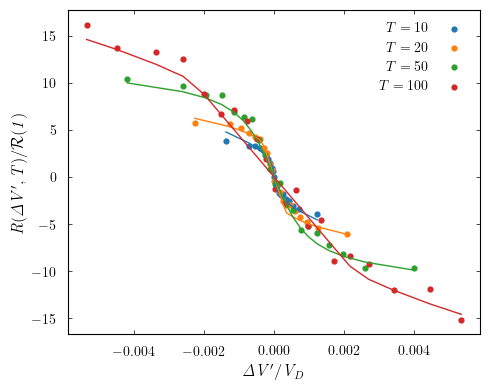

In [144]:
fig = plt.figure(figsize=(5, 4))
ax = fig.gca()

# Smooth data for plotting purposes
smoothed_data = smooth_outliers(normalized_data.copy())

for T, param in fit_param.items():
    params = fit_param[T]
    data = smoothed_data[smoothed_data['T']==T][["T", "volume_imbalance", "R"]]
    binned_data = bin_data_into_quantiles(data, q=21, duplicates="drop")

    T_values = binned_data['T'].values
    volume_imbalance_values = binned_data['volume_imbalance'].values
    R_values = binned_data['R'].values

    # Orderflow imbalance
    orderflow_imbalance = pd.DataFrame({'T': T_values, 'volume_imbalance': -volume_imbalance_values})

    # Compute the model prediction
    model_predictions = scaling_law(orderflow_imbalance, *params)

    plt.scatter(volume_imbalance_values, R_values, label=f"T = {T}", s=12)
    plt.plot(volume_imbalance_values, model_predictions, lw=1)

    xlabel = r"$\it{\Delta V^\prime/V_{D}\langle{V_D}\rangle}$"
    ylabel = r"$\it{R(\Delta V^\prime,T)}$"
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    # PLOTTING SETTINGS
    ax.tick_params(bottom=True, top=True, left=True, right=True, direction="in", width=0.5, size=3)
    ax.minorticks_off()

    xlabel = r"$\it{\Delta V^\prime/V_{D}}$"
    ylabel = r"$\it{R(\Delta V^\prime,T)/\mathcal{R}(1)}$"
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    plt.locator_params(axis='x', nbins=6)
    plt.locator_params(axis='y', nbins=8)


legend = ax.legend(markerfirst=False)
for indx,T in enumerate(fit_param.keys()):
    legend.get_texts()[indx].set_text(f"$T = {int(T)}$")

legend.markerscale = .3
legend.get_frame().set_edgecolor('w')
plt.tight_layout()
plt.savefig("lo-before-col", dpi=300)

#### $3.1.$ Transformer function
The transformer function defines the transformation of our three variables to the new variables $(X, Y)$. It needs the initial values of the shape parameters,  critical exponents $\chi$ and $\varkappa$ from the master curve (scaling law) to perform the renormalization by method of least_squares.

In [149]:
# Prepare the data for fitting
T_values = normalized_data['T'].values
volume_imbalance_values = normalized_data['volume_imbalance'].values
R_values = normalized_data['R'].values

# Fit data for all Ts
master_curve_param = fit_scaling_law(T_values, -volume_imbalance_values, R_values)

# Retrieve optimized parameters as constants
CHI, KAPPA, ALPHA, BETA, CONST = master_curve_param
print(f'chi: {CHI}')
print(f'kappa: {KAPPA}')
print(f'alpha: {ALPHA}')
print(f'beta: {BETA}')
print(f'Const: {CONST}')

rescaled_params = transform(smoothed_data, master_curve_param, BIN_SIZE, reflect_y=True)

/Users/ana_bugaenko/workspace/another_workspace/market_impact/market_impact/response_functions/functional_form.py:26: RuntimeWarning: divide by zero encountered in power
  return x / np.power(1 + np.power(np.abs(x), alpha), beta / alpha) * CONST
/Users/ana_bugaenko/workspace/another_workspace/market_impact/market_impact/response_functions/functional_form.py:26: RuntimeWarning: invalid value encountered in divide
  return x / np.power(1 + np.power(np.abs(x), alpha), beta / alpha) * CONST


chi: -16.377472674756046
kappa: -30.44847153009319
alpha: 0.04727398479977267
beta: 0.461390765631285
Const: 11.118397911682578


In [150]:
rescaled_params = transform(smoothed_data, master_curve_param, BIN_SIZE, reflect_y=True)

We plot a scaling function rescaled by critical paramters $\chi$ and $\varkappa$.

In [151]:
from matplotlib import rc
import matplotlib.font_manager as font_manager
import pylab

pylab.rcParams['xtick.major.pad'] = '8'
pylab.rcParams['ytick.major.pad'] = '8'
rc('text', usetex=True)
rc('mathtext', fontset='stix')
rc('axes', labelsize='large')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{lmodern} \usepackage{amssymb}"

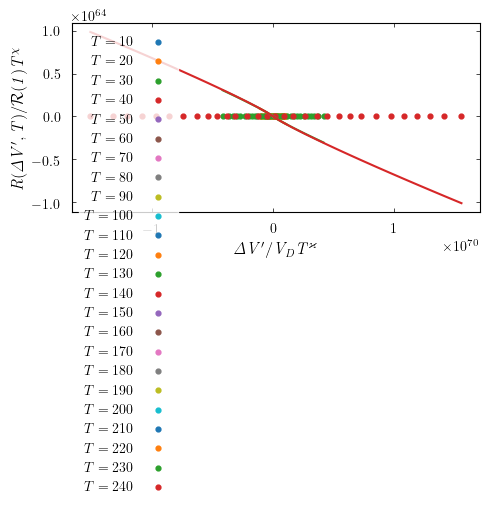

In [152]:
fig = plt.figure(figsize=(5, 4))
ax = fig.gca()

for T, rescaled_param in rescaled_params.items():
    params = rescaled_param.params
    data = rescaled_param.data
    # data = smoothed_data[smoothed_data['T']==T][["volume_imbalance", "T", "R"]]
    binned_data = bin_data_into_quantiles(data, q=31, duplicates="drop")

    T_values = binned_data['T'].values
    volume_imbalance_values = binned_data['volume_imbalance'].values
    R_values = binned_data['R'].values

    orderflow_imbalance = pd.DataFrame({'T': T_values, 'volume_imbalance': -volume_imbalance_values})
    model_predictions = scaling_law(orderflow_imbalance, *params)

    plt.scatter(volume_imbalance_values, R_values, label=f"T = {T}", s=12)
    plt.plot(volume_imbalance_values, model_predictions)

    # PLOTTING SETTINGS
    ax.tick_params(bottom=True, top=True, left=True, right=True, direction="in", width=0.5, size=3)
    ax.minorticks_off()

    xlabel = r"$\it{\Delta V^\prime/V_{D}T^{\varkappa}}$"
    ylabel = r"$\it{R(\Delta V^\prime,T)/\mathcal{R}(1)T^{\chi}}$"
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    plt.locator_params(axis='x', nbins=6)
    plt.locator_params(axis='y', nbins=8)

    # plt.ylim(-1.5, 1.5)
    # plt.xlim(-0.0004, 0.0004)

    # if T == T:
    #     plt.plot(volume_imbalance_values, scaling_function(volume_imbalance_values, master_curve_param[2], master_curve_param[3], master_curve_param[4]) * master_curve_param[-1],
    #              '-', linewidth=1.2, color='black')

legend = ax.legend(markerfirst=False)
for indx,T in enumerate(rescaled_params.keys()):
    legend.get_texts()[indx].set_text(f"$T = {int(T)}$")

legend.markerscale = .3
legend.get_frame().set_edgecolor('w')
plt.tight_layout()
plt.savefig("lo-collapse", dpi=300)
